In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from collections import defaultdict
import numpy as np
import tqdm
import matplotlib.pyplot as plt

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)

train_dataset = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform
)
test_dataset = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform
)

train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=1000, shuffle=False)

class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(32 * 32 * 3, 500)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = x.view(-1, 32 * 32 * 3)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x


model = NeuralNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

num_steps = 10000
eval_steps = 100
check_every = [1, 100, 10000]

losses = defaultdict(list)
permutation = np.random.permutation(32 * 32 * 3)

for step in tqdm.tqdm(range(num_steps + 1)):
    indices = np.random.choice(len(train_dataset), 64)
    images, labels = zip(*[train_dataset[i] for i in indices])
    images = torch.stack(images)
    labels = torch.tensor(labels)
    images = images.to(device)
    labels = labels.to(device)

    outputs = model(images)
    loss = criterion(outputs, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if step in check_every:
        print(f"Reached step {step}, testing plasticity")

        # Train a new model with the same parameters
        new_model = NeuralNet().to(device)
        new_model.load_state_dict(model.state_dict())
        new_optimizer = optim.Adam(new_model.parameters())

        for i in range(eval_steps):
            indices = np.random.choice(len(train_dataset), 64)
            images, labels = zip(*[train_dataset[i] for i in indices])
            images = torch.stack(images)
            labels = torch.tensor(labels)

            # Permute the pixels of the images
            images = images.view(-1, 32 * 32 * 3)
            images = images[:, permutation]
            images = images.view(-1, 3, 32, 32)

            images = images.to(device)
            labels = labels.to(device)

            outputs = new_model(images)
            loss = criterion(outputs, labels)

            new_optimizer.zero_grad()
            loss.backward()
            new_optimizer.step()

            losses[step].append(loss.item())

Running on the GPU
Files already downloaded and verified
Files already downloaded and verified


  0%|                                                                   | 1/10001 [00:00<31:43,  5.25it/s]

Reached step 1, testing plasticity


  1%|▋                                                                 | 95/10001 [00:03<02:31, 65.58it/s]

Reached step 100, testing plasticity


100%|██████████████████████████████████████████████████████████████▉| 10000/10001 [02:15<00:00, 76.51it/s]

Reached step 10000, testing plasticity


100%|███████████████████████████████████████████████████████████████| 10001/10001 [02:17<00:00, 72.89it/s]


In [3]:
print(losses)

defaultdict(<class 'list'>, {1: [2.2522737979888916, 2.3915114402770996, 2.2876715660095215, 2.3777503967285156, 2.3509833812713623, 2.0185256004333496, 2.3854191303253174, 2.026123523712158, 2.1270639896392822, 1.955245852470398, 2.0147979259490967, 2.0189273357391357, 2.0233945846557617, 2.1454527378082275, 2.129429340362549, 2.4019174575805664, 1.9943434000015259, 2.2085442543029785, 2.3425188064575195, 1.9899638891220093, 1.9119240045547485, 1.8625667095184326, 1.9264062643051147, 2.0449018478393555, 1.894842267036438, 1.80146324634552, 2.2834181785583496, 1.9070252180099487, 1.7162917852401733, 1.9106571674346924, 1.8940308094024658, 2.005077362060547, 1.8595463037490845, 2.0930304527282715, 1.8517580032348633, 2.045417547225952, 1.8153055906295776, 1.9756555557250977, 2.085906505584717, 2.243239402770996, 1.7464663982391357, 1.7519530057907104, 2.0072708129882812, 1.7924349308013916, 1.9020485877990723, 1.6842668056488037, 1.7781541347503662, 1.7757047414779663, 1.925118207931518

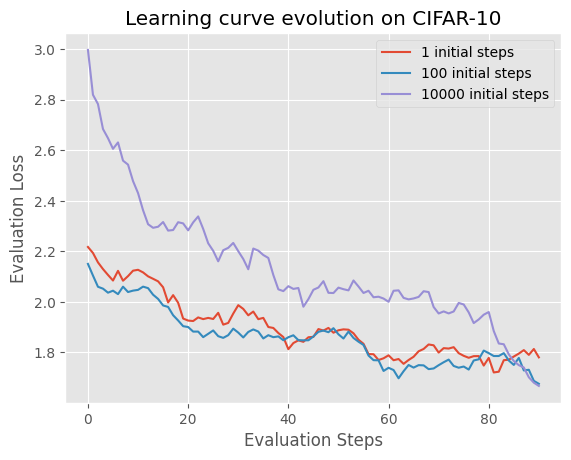

In [20]:
plt.style.use('ggplot')
for step, loss in losses.items():
    plt.plot(
        np.convolve(loss, np.ones(10) / 10, mode="valid"),
        label=f"{step} initial steps",
    )

plt.title("Learning curve evolution on CIFAR-10")
plt.xlabel("Evaluation Steps")
plt.ylabel("Evaluation Loss")
plt.legend()
plt.savefig("img/cifar.pdf", format="pdf", bbox_inches="tight")


In [95]:
import os
import itertools
import matplotlib.pyplot as plt
import numpy as np
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

def get_data(folder, scalar_keys, base_dir="data_final"):
    log_file = sorted(os.listdir(f"{base_dir}/{folder}"))[0]
    event_acc = EventAccumulator(f"{base_dir}/{folder}/{log_file}")
    event_acc.Reload()

    if isinstance(scalar_keys, str):
        scalar_keys = [scalar_keys]

    scalars = {}
    for tag in scalar_keys:
        scalars_for_tag = event_acc.Scalars(tag)
        scalars[tag] = {
            "step": [s.step for s in scalars_for_tag],
            "wall_time": [s.wall_time for s in scalars_for_tag],
            "value": [s.value for s in scalars_for_tag],
        }

    return scalars

In [125]:
# breakout_baseline = "breakout_BreakoutNoFrameskip-v4_05-12-2023_02-50-09_clip10.0/tensorboard"
# breakout_baseline_data = get_data(breakout_baseline, "eval_return")

# breakout_rql = "breakout_swap_critic_once_BreakoutNoFrameskip-v4_13-12-2023_06-05-02_clip10.0/tensorboard"
# breakout_rql_data = get_data(breakout_rql, "eval_return")

# breakout_sw = "breakout_swap_critic_once_10epochs_BreakoutNoFrameskip-v4_13-12-2023_06-05-30_clip10.0/tensorboard"
# breakout_sw_data = get_data(breakout_sw, "eval_return")

# breakout_l2 = "breakout_l2_regularization_BreakoutNoFrameskip-v4_13-12-2023_08-50-39_clip10.0/tensorboard"
# breakout_l2_data = get_data(breakout_l2, "eval_return")

# cartpole_baseline = "cartpole_baseline/tensorboard"
# cartpole_baseline_data = get_data(cartpole_baseline, "eval_return")

# cartpole_rql = "cartpole_rql_CartPole-v0_13-12-2023_07-48-05/tensorboard"
# cartpole_rql_data = get_data(cartpole_rql, "eval_return")

# cartpole_sw = "cartpole_swap_critic_many_steps_CartPole-v0_13-12-2023_02-16-27/tensorboard"
# cartpole_sw = get_data(cartpole_sw, "eval_return")

# cartpole_l2 = "cartpole_l2_CartPole-v0_13-12-2023_22-48-43/tensorboard"
# cartpole_l2 = get_data(cartpole_l2, "eval_return")

experiments = {
    "Breakout Vanilla DQN": "breakout_BreakoutNoFrameskip-v4_05-12-2023_02-50-09_clip10.0/tensorboard",
    "Breakout RQL": "breakout_rql_fixed_BreakoutNoFrameskip-v4_14-12-2023_00-39-53_clip10.0/tensorboard",
    "Breakout Critic Swap": "breakout_swap_critic_once_10epochs_BreakoutNoFrameskip-v4_13-12-2023_06-05-30_clip10.0/tensorboard",
    "Breakout $l_2$ Regularization": "breakout_l2_regularization_BreakoutNoFrameskip-v4_13-12-2023_08-50-39_clip10.0/tensorboard",
    "Cartpole Vanilla DQN": "cartpole_baseline/tensorboard",
    "Cartpole RQL": "cartpole_rql_CartPole-v0_13-12-2023_07-48-05/tensorboard",
    "Cartpole Critic Swap": "cartpole_swap_critic_many_steps_CartPole-v0_13-12-2023_02-16-27/tensorboard",
    "Cartpole $l_2$ Regularization": "cartpole_l2_CartPole-v0_13-12-2023_22-48-43/tensorboard"
}

data = {key: get_data(value, ["eval_return", "critic_loss"]) for key, value in experiments.items()}

270000.0 290000
270000.0 290000
270000.0 290000
270000.0 290000


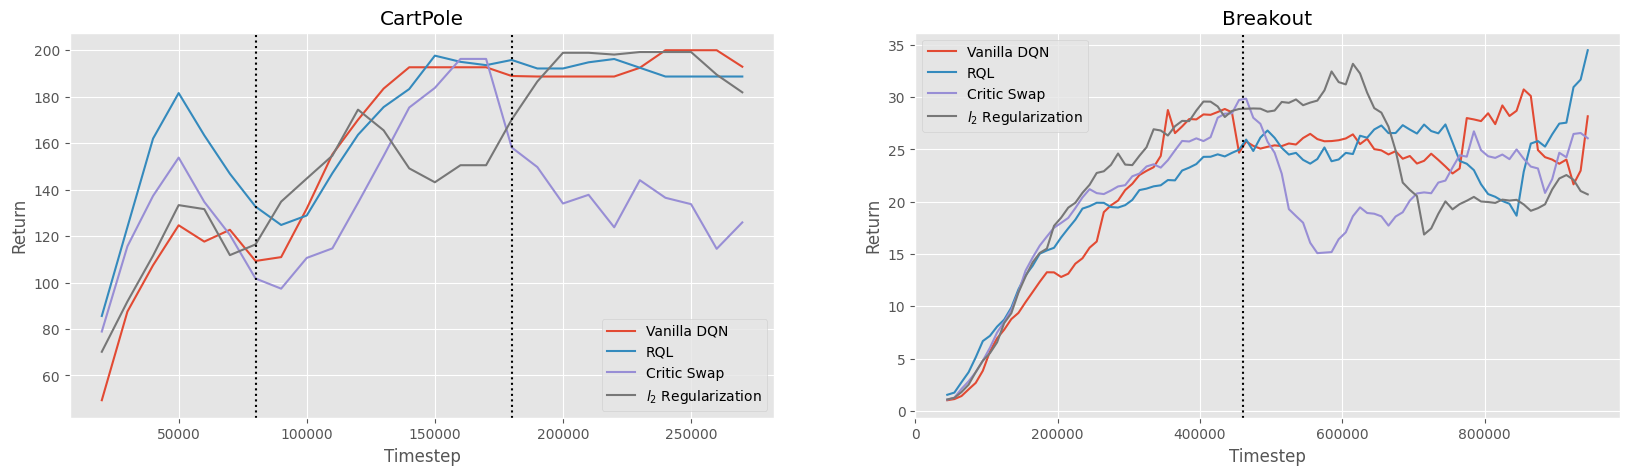

In [130]:
# Function to calculate sliding window average
def sliding_window_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# Your existing setup for plots
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
ax[0].set_xlabel("Timestep")
ax[0].set_ylabel("Return")
ax[1].set_xlabel("Timestep")
ax[1].set_ylabel("Return")
ax[0].set_title("CartPole")
ax[1].set_title("Breakout")


for experiment in experiments:
    window_size = 5 if "Cartpole" in experiment else 10
    smoothed_steps = sliding_window_average(data[experiment]["eval_return"]["step"], window_size)
    smoothed_values = sliding_window_average(data[experiment]["eval_return"]["value"], window_size)
    if "Breakout" in experiment:
        ax[1].plot(smoothed_steps, smoothed_values, label=experiment.replace("Breakout ", ""))
    else:
        ax[0].plot(smoothed_steps, smoothed_values, label=experiment.replace("Cartpole ", ""))
        print(max(smoothed_steps), max(data[experiment]["eval_return"]["step"]))


ax[1].legend()
ax[1].axvline(515000 - 55000, color="black", linestyle="dotted")
ax[0].legend()
ax[0].axvline(100000 - 20000, color="black", linestyle="dotted")
ax[0].legend()
ax[0].axvline(200000 - 20000, color="black", linestyle="dotted")

plt.savefig("img/rql_main.pdf", format="pdf", bbox_inches="tight")

In [131]:
def get_dict(d):
    return {k: get_data(v, "eval_return") for k, v in d.items()}

epochs = {
    "0 Epochs": "breakout_BreakoutNoFrameskip-v4_05-12-2023_02-50-09_clip10.0/tensorboard",
    "5 Epochs": "breakout_rql_fixed_BreakoutNoFrameskip-v4_14-12-2023_00-39-53_clip10.0/tensorboard",
    "10 Epochs": "breakout_swap_critic_once_10epochs_BreakoutNoFrameskip-v4_13-12-2023_06-05-30_clip10.0/tensorboard"
}
epochs_data = get_dict(epochs)

eps = {
    "High $\epsilon$ value": "breakout_rql_higheps_BreakoutNoFrameskip-v4_13-12-2023_08-05-51_clip10.0/tensorboard",
    "Low $\epsilon$ value": "breakout_rql_fixed_BreakoutNoFrameskip-v4_14-12-2023_00-39-53_clip10.0/tensorboard"
}
eps_data = get_dict(eps)

swap = {
    "Two Swaps": "breakout_swap_critic_BreakoutNoFrameskip-v4_13-12-2023_04-28-31_clip10.0/tensorboard",
    "One Swap": "breakout_rql_fixed_BreakoutNoFrameskip-v4_14-12-2023_00-39-53_clip10.0/tensorboard",
    "No Swaps": "breakout_BreakoutNoFrameskip-v4_05-12-2023_02-50-09_clip10.0/tensorboard",
}
swap_data = get_dict(swap)

weight = {
    "Constant": "breakout_rql_normeps_BreakoutNoFrameskip-v4_13-12-2023_09-29-33_clip10.0/tensorboard",
    "Exponential": "breakout_rql_fixed_BreakoutNoFrameskip-v4_14-12-2023_00-39-53_clip10.0/tensorboard",
}
weight_data = get_dict(weight)

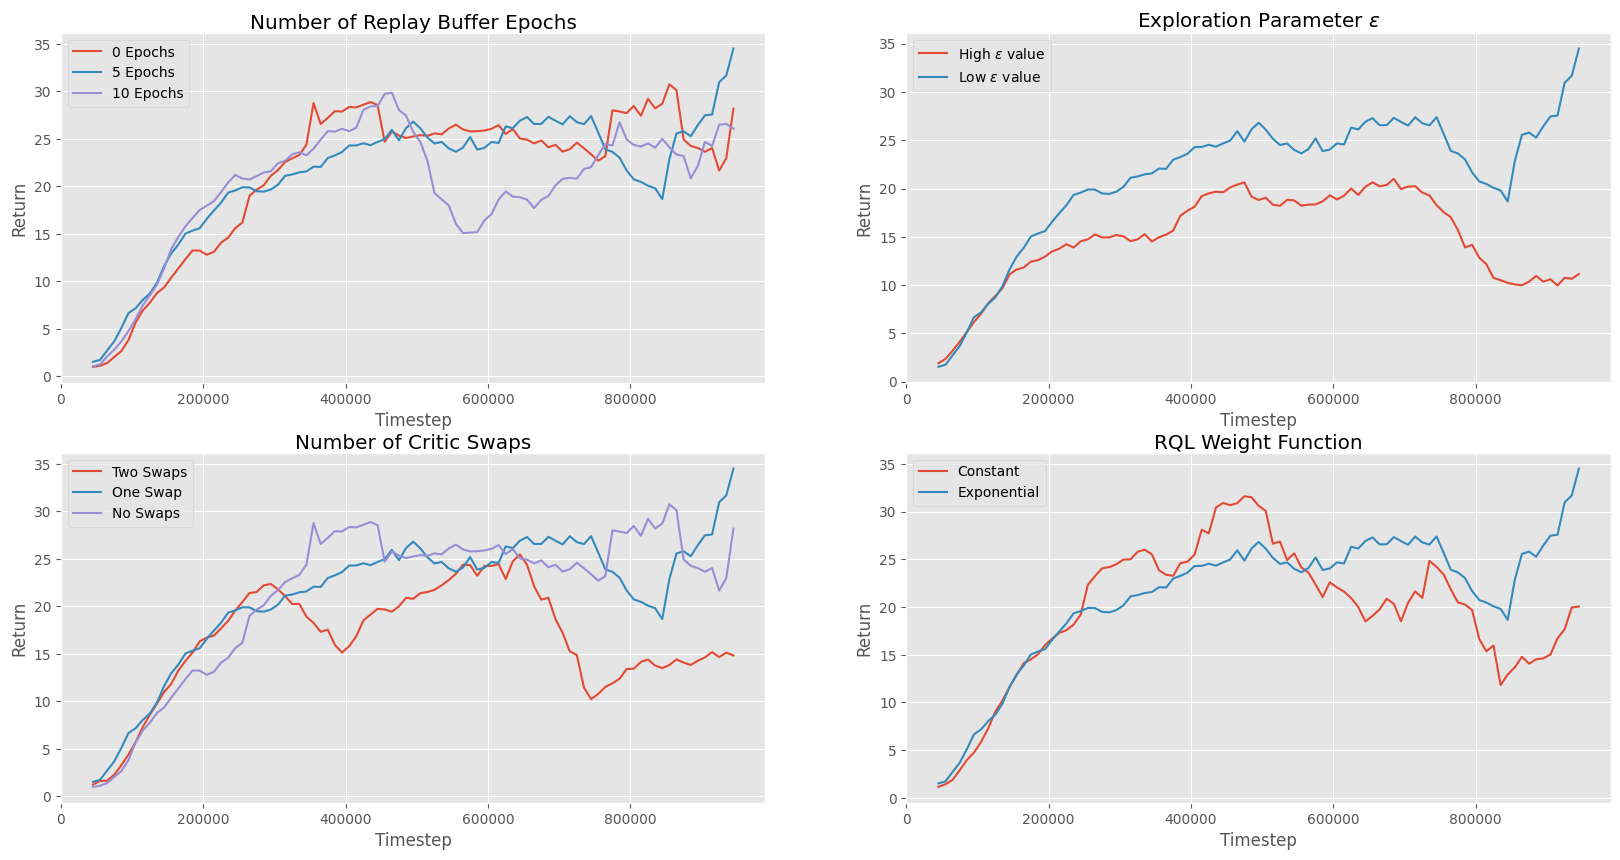

In [133]:
fig, ax = plt.subplots(2, 2, figsize=(20, 10))

def plot_dict(ax, data, title):
    for experiment in data:
        smoothed_steps = sliding_window_average(data[experiment]["eval_return"]["step"], 10)
        smoothed_values = sliding_window_average(data[experiment]["eval_return"]["value"], 10)
        ax.plot(smoothed_steps, smoothed_values, label=experiment)
        
    ax.legend()
    ax.set_title(title, pad=-20)
    ax.set_xlabel("Timestep")
    ax.set_ylabel("Return")

plot_dict(ax[0][0], epochs_data, "Number of Replay Buffer Epochs")
plot_dict(ax[0][1], eps_data, "Exploration Parameter $\epsilon$")
plot_dict(ax[1][0], swap_data, "Number of Critic Swaps")
plot_dict(ax[1][1], weight_data, "RQL Weight Function")

plt.savefig("img/rql_ablations.pdf", format="pdf", bbox_inches="tight")